In [2]:
import os
import torch
import pandas as pd
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [3]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

### Load Data

In [45]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(18),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224,0.225] )
])

In [46]:
dataset_path = 'dataset'

dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2300

In [47]:
print(dataset.classes)

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']


In [58]:
num_classes = len(dataset.classes)
num_classes

6

In [49]:
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size

In [50]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [51]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [52]:
for image, label in train_loader:
     print(image.size())
     print(label.size())
     break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [53]:
label[0]

tensor(1)

In [54]:
image[0].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


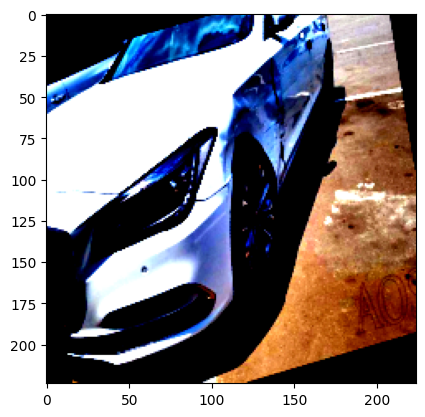

In [56]:
plt.imshow(image[0].permute(1,2,0))

### Model 1: CNN Model Training

In [73]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=64 , kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            ,nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.network(x)
        return x

In [66]:
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [71]:
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5):

    for epoch in range(epochs):
        start = time.time()
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item() :0.2f}")
            running_loss += loss.item() / len(train_loader.dataset)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss: 4f}")

        model.eval()
        with torch.no_grad():
            total = 0
            correct = 0
            all_labels = []
            all_predictions = []
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += label.size(0)
                all_predictions.append(predicted.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
            print('Validation Accuracy: {:.4f}'.format(100 * correct / total))
        end = time.time()
        print(f"Execution time: {end - start} seconds")
    return all_labels, all_predictions

In [72]:
all_labels, all_predictions = train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5)

Batch: 10, Epoch: 1, Loss: 0.96
Batch: 20, Epoch: 1, Loss: 1.29
Batch: 30, Epoch: 1, Loss: 1.26
Batch: 40, Epoch: 1, Loss: 1.20
Batch: 50, Epoch: 1, Loss: 0.84
Epoch [1/5], Avg Loss:  0.000020
Validation Accuracy: 52.6042
Execution time: 28.039933919906616 seconds
Batch: 10, Epoch: 2, Loss: 1.15
Batch: 20, Epoch: 2, Loss: 0.98
Batch: 30, Epoch: 2, Loss: 1.04
Batch: 40, Epoch: 2, Loss: 0.97
Batch: 50, Epoch: 2, Loss: 1.04
Epoch [2/5], Avg Loss:  0.000019
Validation Accuracy: 52.9514
Execution time: 27.459662914276123 seconds
Batch: 10, Epoch: 3, Loss: 0.97
Batch: 20, Epoch: 3, Loss: 1.04
Batch: 30, Epoch: 3, Loss: 1.14
Batch: 40, Epoch: 3, Loss: 0.80
Batch: 50, Epoch: 3, Loss: 1.06
Epoch [3/5], Avg Loss:  0.000017
Validation Accuracy: 54.8611
Execution time: 27.558767080307007 seconds
Batch: 10, Epoch: 4, Loss: 0.85
Batch: 20, Epoch: 4, Loss: 0.69
Batch: 30, Epoch: 4, Loss: 0.89
Batch: 40, Epoch: 4, Loss: 1.08
Batch: 50, Epoch: 4, Loss: 0.80
Epoch [4/5], Avg Loss:  0.000016
Validation A

### Model 2 : CNN Model with Regularization

In [74]:
class CarClassifierCNNReg(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=64 , kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            ,nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.network(x)
        return x

In [76]:
model = CarClassifierCNNReg(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [77]:
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5):

    for epoch in range(epochs):
        start = time.time()
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item() :0.2f}")
            running_loss += loss.item() / len(train_loader.dataset)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss: 4f}")

        model.eval()
        with torch.no_grad():
            total = 0
            correct = 0
            all_labels = []
            all_predictions = []
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += label.size(0)
                all_predictions.append(predicted.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
            print('Validation Accuracy: {:.4f}'.format(100 * correct / total))
        end = time.time()
        print(f"Execution time: {end - start} seconds")
    return all_labels, all_predictions

In [78]:
all_labels, all_predictions = train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5)

Batch: 10, Epoch: 1, Loss: 12.78
Batch: 20, Epoch: 1, Loss: 6.01
Batch: 30, Epoch: 1, Loss: 2.33
Batch: 40, Epoch: 1, Loss: 1.77
Batch: 50, Epoch: 1, Loss: 1.40
Epoch [1/5], Avg Loss:  0.000132
Validation Accuracy: 36.8056
Execution time: 30.10021185874939 seconds
Batch: 10, Epoch: 2, Loss: 1.34
Batch: 20, Epoch: 2, Loss: 1.47
Batch: 30, Epoch: 2, Loss: 1.30
Batch: 40, Epoch: 2, Loss: 1.36
Batch: 50, Epoch: 2, Loss: 1.51
Epoch [2/5], Avg Loss:  0.000027
Validation Accuracy: 42.1875
Execution time: 28.530019998550415 seconds
Batch: 10, Epoch: 3, Loss: 1.27
Batch: 20, Epoch: 3, Loss: 1.41
Batch: 30, Epoch: 3, Loss: 1.30
Batch: 40, Epoch: 3, Loss: 1.12
Batch: 50, Epoch: 3, Loss: 1.65
Epoch [3/5], Avg Loss:  0.000025
Validation Accuracy: 41.1458
Execution time: 29.399631023406982 seconds
Batch: 10, Epoch: 4, Loss: 1.40
Batch: 20, Epoch: 4, Loss: 1.56
Batch: 30, Epoch: 4, Loss: 1.31
Batch: 40, Epoch: 4, Loss: 2.22
Batch: 50, Epoch: 4, Loss: 1.24
Epoch [4/5], Avg Loss:  0.000025
Validation A

### Model 3 : Transfer Learning with EfficientNet

In [79]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        for param in self.model.parameters():
            param.requires_grad = False

        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features, num_classes)
        )
    def forward(self, x):
        x = self.model(x)
        return x


In [81]:
model = CarClassifierEfficientNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p : p.requires_grad, model.parameters() ), lr=0.001)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/sheetals/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:06<00:00, 3.07MB/s]


In [83]:
train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5)

Batch: 10, Epoch: 1, Loss: 1.67
Batch: 20, Epoch: 1, Loss: 1.45
Batch: 30, Epoch: 1, Loss: 1.32
Batch: 40, Epoch: 1, Loss: 1.30
Batch: 50, Epoch: 1, Loss: 1.28
Epoch [1/5], Avg Loss:  0.000026
Validation Accuracy: 55.3819
Execution time: 33.25842881202698 seconds
Batch: 10, Epoch: 2, Loss: 1.14
Batch: 20, Epoch: 2, Loss: 1.06
Batch: 30, Epoch: 2, Loss: 1.05
Batch: 40, Epoch: 2, Loss: 0.98
Batch: 50, Epoch: 2, Loss: 1.11
Epoch [2/5], Avg Loss:  0.000019
Validation Accuracy: 61.1111
Execution time: 31.423798084259033 seconds
Batch: 10, Epoch: 3, Loss: 0.97
Batch: 20, Epoch: 3, Loss: 0.85
Batch: 30, Epoch: 3, Loss: 1.01
Batch: 40, Epoch: 3, Loss: 0.83
Batch: 50, Epoch: 3, Loss: 1.01
Epoch [3/5], Avg Loss:  0.000017
Validation Accuracy: 62.5000
Execution time: 31.96042823791504 seconds
Batch: 10, Epoch: 4, Loss: 0.88
Batch: 20, Epoch: 4, Loss: 0.87
Batch: 30, Epoch: 4, Loss: 0.81
Batch: 40, Epoch: 4, Loss: 1.03
Batch: 50, Epoch: 4, Loss: 0.87
Epoch [4/5], Avg Loss:  0.000016
Validation Acc

([array([0, 2, 2, 2, 0, 3, 0, 1, 2, 2, 5, 0, 2, 1, 5, 2, 0, 2, 3, 2, 2, 3,
         5, 0, 3, 1, 0, 2, 1, 4, 5, 3]),
  array([0, 2, 3, 2, 3, 4, 0, 3, 4, 3, 5, 3, 0, 1, 3, 4, 1, 4, 5, 0, 1, 2,
         3, 0, 5, 0, 0, 5, 3, 2, 0, 0]),
  array([0, 1, 3, 2, 1, 2, 5, 5, 5, 2, 5, 2, 5, 5, 3, 2, 3, 0, 1, 4, 3, 4,
         5, 5, 3, 3, 3, 0, 4, 1, 5, 1]),
  array([2, 3, 0, 3, 2, 1, 3, 0, 3, 0, 0, 2, 5, 2, 0, 4, 1, 3, 1, 4, 2, 2,
         4, 0, 1, 2, 4, 1, 4, 2, 5, 1]),
  array([4, 2, 1, 5, 2, 0, 1, 5, 0, 2, 1, 1, 0, 0, 1, 4, 5, 1, 1, 0, 3, 5,
         0, 3, 4, 2, 4, 1, 3, 4, 4, 0]),
  array([2, 1, 3, 2, 0, 0, 3, 2, 2, 2, 5, 4, 0, 5, 1, 5, 2, 4, 2, 0, 2, 3,
         1, 4, 2, 5, 4, 3, 1, 2, 3, 1]),
  array([4, 0, 5, 2, 0, 0, 1, 2, 3, 4, 4, 5, 3, 1, 1, 2, 0, 0, 4, 3, 1, 4,
         2, 1, 0, 3, 5, 1, 2, 2, 5, 4]),
  array([5, 5, 2, 2, 0, 0, 1, 4, 5, 1, 0, 1, 2, 3, 0, 1, 5, 4, 5, 5, 5, 2,
         0, 0, 4, 1, 3, 5, 0, 5, 0, 4]),
  array([1, 4, 0, 0, 2, 1, 4, 3, 1, 0, 2, 5, 1, 3, 3, 3, 2, 1, 5, 1, 3, 

### Model 4 : Transfer Learning with ResNet

In [100]:
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.layer4.parameters():
            param.requires_grad = True


        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )
    def forward(self, x):
        x = self.model(x)
        return x


In [86]:
model = CarClassifierResNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p : p.requires_grad, model.parameters() ), lr=0.001)
train_model(model, optimizer, criterion, train_loader, val_loader, epochs=10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/sheetals/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:32<00:00, 3.14MB/s]


Batch: 10, Epoch: 1, Loss: 0.91
Batch: 20, Epoch: 1, Loss: 0.71
Batch: 30, Epoch: 1, Loss: 0.85
Batch: 40, Epoch: 1, Loss: 0.95
Batch: 50, Epoch: 1, Loss: 0.58
Epoch [1/10], Avg Loss:  0.000016
Validation Accuracy: 73.9583
Execution time: 46.23990297317505 seconds
Batch: 10, Epoch: 2, Loss: 0.39
Batch: 20, Epoch: 2, Loss: 0.29
Batch: 30, Epoch: 2, Loss: 0.43
Batch: 40, Epoch: 2, Loss: 0.40
Batch: 50, Epoch: 2, Loss: 0.49
Epoch [2/10], Avg Loss:  0.000008
Validation Accuracy: 75.0000
Execution time: 44.47982907295227 seconds
Batch: 10, Epoch: 3, Loss: 0.59
Batch: 20, Epoch: 3, Loss: 0.17
Batch: 30, Epoch: 3, Loss: 0.30
Batch: 40, Epoch: 3, Loss: 0.44
Batch: 50, Epoch: 3, Loss: 0.21
Epoch [3/10], Avg Loss:  0.000006
Validation Accuracy: 77.9514
Execution time: 44.916000843048096 seconds
Batch: 10, Epoch: 4, Loss: 0.18
Batch: 20, Epoch: 4, Loss: 0.45
Batch: 30, Epoch: 4, Loss: 0.42
Batch: 40, Epoch: 4, Loss: 0.20
Batch: 50, Epoch: 4, Loss: 0.12
Epoch [4/10], Avg Loss:  0.000005
Validation

([array([5, 2, 0, 4, 0, 0, 4, 1, 5, 3, 4, 5, 3, 5, 3, 2, 0, 1, 4, 2, 2, 0,
         1, 5, 2, 2, 4, 1, 2, 2, 0, 5]),
  array([2, 0, 1, 1, 3, 2, 4, 1, 5, 2, 1, 5, 3, 1, 0, 0, 1, 4, 2, 2, 2, 5,
         4, 4, 5, 0, 3, 4, 1, 0, 0, 3]),
  array([4, 2, 2, 5, 5, 5, 3, 3, 1, 1, 0, 0, 2, 0, 3, 4, 1, 1, 1, 2, 2, 5,
         1, 4, 4, 2, 4, 1, 0, 5, 1, 0]),
  array([4, 3, 1, 3, 4, 4, 5, 5, 0, 2, 3, 2, 1, 2, 0, 1, 4, 1, 1, 5, 1, 5,
         2, 2, 0, 0, 0, 1, 0, 3, 2, 0]),
  array([0, 1, 0, 2, 3, 3, 4, 0, 3, 0, 2, 4, 5, 1, 1, 1, 1, 4, 0, 1, 1, 2,
         2, 2, 4, 0, 0, 5, 5, 5, 5, 0]),
  array([5, 1, 4, 1, 4, 1, 0, 2, 0, 2, 1, 0, 5, 2, 0, 5, 2, 3, 3, 3, 5, 4,
         3, 4, 0, 4, 0, 0, 1, 1, 4, 1]),
  array([3, 5, 2, 4, 0, 1, 5, 4, 1, 4, 0, 5, 1, 0, 1, 5, 3, 4, 0, 2, 5, 0,
         3, 4, 0, 3, 5, 1, 1, 0, 3, 0]),
  array([0, 5, 0, 2, 0, 2, 0, 0, 0, 1, 2, 2, 3, 1, 4, 2, 5, 2, 2, 2, 2, 3,
         4, 4, 5, 0, 2, 4, 1, 4, 3, 2]),
  array([2, 5, 2, 3, 2, 3, 4, 0, 0, 3, 1, 0, 4, 4, 2, 5, 2, 4, 5, 3, 0, 

### Model 5 : Hypertuning the parameters (ResNet)

In [87]:
class CarClassifierResNetTuned(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.layer4.parameters():
            param.requires_grad = True


        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )
    def forward(self, x):
        x = self.model(x)
        return x


In [97]:
import optuna


def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)
    model = CarClassifierResNetTuned(num_classes=num_classes, dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p : p.requires_grad, model.parameters() ), lr=lr)

    epochs = 3
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            running_loss += loss.item() * image.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        with torch.no_grad():
            total = 0
            correct = 0

            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += label.size(0)
            accuracy = correct / total
            trial.report(accuracy, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
    end = time.time()
    print(f"Execution time: {end - start} seconds")
    return accuracy


In [99]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

In [116]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")

    end = time.time()
    print(f"Execution time: {end - start} seconds")

    return all_labels, all_predictions

In [117]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [118]:
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.09
Batch: 20, Epoch: 1, Loss: 0.72
Batch: 30, Epoch: 1, Loss: 0.87
Batch: 40, Epoch: 1, Loss: 0.83
Batch: 50, Epoch: 1, Loss: 0.86
Epoch [1/10], Avg Loss: 0.9115
*** Validation Accuracy: 67.48% ***
Batch: 10, Epoch: 2, Loss: 0.40
Batch: 20, Epoch: 2, Loss: 0.47
Batch: 30, Epoch: 2, Loss: 0.72
Batch: 40, Epoch: 2, Loss: 0.47
Batch: 50, Epoch: 2, Loss: 0.49
Epoch [2/10], Avg Loss: 0.5140
*** Validation Accuracy: 75.65% ***
Batch: 10, Epoch: 3, Loss: 0.23
Batch: 20, Epoch: 3, Loss: 0.47
Batch: 30, Epoch: 3, Loss: 0.30
Batch: 40, Epoch: 3, Loss: 0.35
Batch: 50, Epoch: 3, Loss: 0.65
Epoch [3/10], Avg Loss: 0.3883
*** Validation Accuracy: 79.65% ***
Batch: 10, Epoch: 4, Loss: 0.22
Batch: 20, Epoch: 4, Loss: 0.22
Batch: 30, Epoch: 4, Loss: 0.11
Batch: 40, Epoch: 4, Loss: 0.23
Batch: 50, Epoch: 4, Loss: 0.23
Epoch [4/10], Avg Loss: 0.2862
*** Validation Accuracy: 78.78% ***
Batch: 10, Epoch: 5, Loss: 0.21
Batch: 20, Epoch: 5, Loss: 0.13
Batch: 30, Epoch: 5, Loss: 0

In [101]:
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p : p.requires_grad, model.parameters() ), lr=0.005)

In [102]:
labels, predictions = train_model(model, optimizer, criterion, train_loader, val_loader, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.19
Batch: 20, Epoch: 1, Loss: 0.81
Batch: 30, Epoch: 1, Loss: 0.79
Batch: 40, Epoch: 1, Loss: 0.61
Batch: 50, Epoch: 1, Loss: 0.94
Epoch [1/10], Avg Loss:  0.000016
Validation Accuracy: 71.1806
Execution time: 44.12180209159851 seconds
Batch: 10, Epoch: 2, Loss: 0.48
Batch: 20, Epoch: 2, Loss: 0.35
Batch: 30, Epoch: 2, Loss: 0.48
Batch: 40, Epoch: 2, Loss: 0.44
Batch: 50, Epoch: 2, Loss: 0.68
Epoch [2/10], Avg Loss:  0.000009
Validation Accuracy: 73.2639
Execution time: 43.73208284378052 seconds
Batch: 10, Epoch: 3, Loss: 0.33
Batch: 20, Epoch: 3, Loss: 0.58
Batch: 30, Epoch: 3, Loss: 0.63
Batch: 40, Epoch: 3, Loss: 0.44
Batch: 50, Epoch: 3, Loss: 0.97
Epoch [3/10], Avg Loss:  0.000009
Validation Accuracy: 70.3125
Execution time: 49.871201038360596 seconds
Batch: 10, Epoch: 4, Loss: 0.24
Batch: 20, Epoch: 4, Loss: 0.36
Batch: 30, Epoch: 4, Loss: 0.41
Batch: 40, Epoch: 4, Loss: 0.29
Batch: 50, Epoch: 4, Loss: 0.17
Epoch [4/10], Avg Loss:  0.000006
Validation

### Model Evaluation using confusion matrix and classification report

In [119]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)


              precision    recall  f1-score   support

           0       0.76      0.89      0.82       123
           1       0.84      0.49      0.62       107
           2       0.76      0.92      0.84       113
           3       0.84      0.76      0.79        74
           4       0.68      0.67      0.68        76
           5       0.78      0.87      0.82        82

    accuracy                           0.77       575
   macro avg       0.78      0.77      0.76       575
weighted avg       0.78      0.77      0.76       575



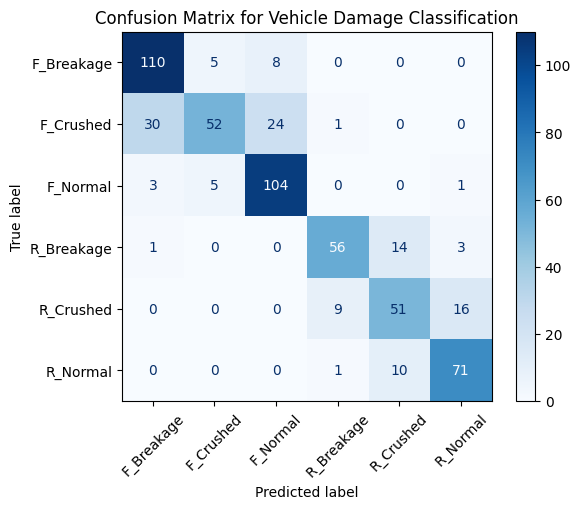

In [120]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

class_names = dataset.classes
conf_matrix = confusion_matrix(labels, predictions, labels=np. arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt. show ()

In [121]:
torch.save(model.state_dict(), 'saved_model.pth')